# Importing all required resources

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!pip install transformers
!pip install tqdm

     |████████████████████████████████| 1.4MB 15.6MB/s 
     |████████████████████████████████| 2.9MB 35.6MB/s 
     |████████████████████████████████| 890kB 49.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=9e1f5e1705a18e1bb3c10e2e2d1c29636d6fa68c189b31e1525e0cd203ce2cac
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import seaborn as sn
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoModel
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score,precision_score,recall_score
from tqdm import tqdm
import random

torch.backends.cudnn.deterministic = True
torch.manual_seed(123)
torch.cuda.manual_seed_all(123)
np.random.seed(123)
random.seed(123)
torch.cuda.manual_seed_all(123)

#Using HINDI BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("monsoon-nlp/hindi-bert")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Input files
df = pd.read_csv("/content/gdrive/My Drive/CS685/constraint_hindi_train.csv")
#Making Taglist
taglist = list()
for i in range(len(df)):
    tags = df.iloc[i]["Labels Set"].split(",")
    for tag in tags:
        if(tag not in taglist):
            taglist.append(tag)

ModuleNotFoundError: ignored

In [ ]:
#Creating the class for dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, datapath):
        self.df = pd.read_csv(datapath)
    def __len__(self):
        return(len(self.df))
    def __getitem__(self,idx):
        sentence = self.df.iloc[idx]["Post"]
        encoding = tokenizer.encode_plus(sentence,add_special_tokens=True,max_length=64,truncation=True,pad_to_max_length=True,return_attention_mask=True)
        input_ids = encoding['input_ids']
        attention_mask = encoding['attention_mask']
        labels = np.zeros(5)
        tags = self.df.iloc[idx]["Labels Set"].split(",")
        for tag in tags:
            labels[taglist.index(tag)] = 1
        return np.array(input_ids), np.array(attention_mask), labels
trainset = Dataset("/content/gdrive/My Drive/CS685/constraint_hindi_train.csv")
valset = Dataset("/content/gdrive/My Drive/CS685/constraint_hindi_valid.csv")

trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size = 64, shuffle=True)

#Model

In [ ]:
class bert_model(nn.Module): ## CNN + Linear (single linear)
    def __init__(self):
        super(bert_model, self).__init__()
        self.bert = AutoModel.from_pretrained("monsoon-nlp/hindi-bert", output_hidden_states=True)
        # self.bert = AutoModel.from_pretrained("monsoon-nlp/hindi-tpu-electra", output_hidden_states=True)
        self.convs = nn.ModuleList([nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3, 256), padding=(1,0)) for i in range(12)])
        self.pools = nn.ModuleList([nn.MaxPool1d(kernel_size=64) for i in range(12)])
        self.linear = nn.Linear(in_features=12, out_features=5)
        self.sigmoid = nn.Sigmoid()
    def forward(self,sent,mask):
        seq = self.bert(sent,mask)[1] # len 13
        hidden_states = seq[1:] # len 12, each (64, 64, bert_hidden_size)
        cnn_out = torch.empty(0).to(device)
        for i, state in enumerate(hidden_states):
            state = torch.unsqueeze(state, dim=1) # (64, 1, 64, bert_hidden_size)
            out = self.convs[i](state) # (64, 1, 64, 1)
            out = out.squeeze(dim=3)
            out = self.pools[i](out) # (64, 1, 1)
            out = out.squeeze(dim=2) # (64, 1)
            cnn_out = torch.cat([cnn_out, out], dim=1)

        seq = self.linear(cnn_out)
        seq = self.sigmoid(seq)
        return seq
# class bert_model(nn.Module): ## Linear on bert (single linear)
#     def __init__(self):
#         super(bert_model, self).__init__()
#         self.bert = AutoModel.from_pretrained("monsoon-nlp/hindi-bert")
#         self.linear = nn.Linear(in_features=256, out_features=5)
#         self.sigmoid = nn.Sigmoid()
#     def forward(self,sent,mask):
#         seq = self.bert(sent,mask)[0]
#         seq = torch.mean(seq, dim = 1).squeeze()
#         seq = self.linear(seq)
#         seq = self.sigmoid(seq)
#         return seq
# class bert_model(nn.Module): #(lstm + single linear layer)
#     def __init__(self):
#         super(bert_model, self).__init__()
#         self.bert = AutoModel.from_pretrained("monsoon-nlp/hindi-bert")
#         self.lstm=nn.LSTM(input_size=256,hidden_size=300,batch_first=True, bidirectional=True)
#         self.linear = nn.Linear(in_features=600, out_features=5)
#         self.sigmoid = nn.Sigmoid()
#     def forward(self,sent,mask):
#         self.lstm.flatten_parameters
#         seq = self.bert(sent,mask)[0]
#         seq,(hn,cn) = self.lstm(seq)
#         seq = torch.mean(seq, dim = 1).squeeze()
#         seq = self.linear(seq)
#         seq = self.sigmoid(seq)
#         return seq
model = bert_model()
model.to(device)

#Training

In [ ]:
train_losses = list()
val_losses=list()
val_accuracy=list()
loss = nn.BCELoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5)
for epoch in (range(60)):
    model.train()
    total_loss=0
    num_batches = 0
    ## main model training loop
    for batch in (trainloader):
        optimizer.zero_grad()
        batch[0],batch[1],batch[2] = batch[0].to("cuda"), batch[1].to("cuda"), batch[2].to("cuda")
        logits = model(batch[0],batch[1])
        labels = batch[2]

        loss_value = loss(logits.float(),labels.float())
        loss_value.backward()
        optimizer.step()

        total_loss+=loss_value.item()
        num_batches +=1
        torch.cuda.empty_cache()
    train_losses.append(total_loss/num_batches)
    if(epoch%1==0):
        print("train loss at epoch " + str(epoch) + ":" + str(total_loss/num_batches))

    model.eval()
    total_loss=0
    num_batches = 0
    ## validation loss and F1 score calculation
    for batch in (valloader):
        batch[0],batch[1], batch[2] = batch[0].to("cuda"), batch[1].to("cuda"), batch[2].to("cuda")
        logits = model(batch[0],batch[1])
        labels = batch[2]

        loss_value = loss(logits.float(),labels.float())
        total_loss+=loss_value.item()
        num_batches +=1
        torch.cuda.empty_cache()
    val_losses.append(total_loss/num_batches)
    if(epoch%1==0):
        print("val loss at epoch " + str(epoch) + ":" + str(total_loss/num_batches))
        
    logits_list = np.zeros((1,5))
    labels_list = np.zeros((1,5))
    for batch in (valloader):
        batch[0],batch[1], batch[2] = batch[0].to("cuda"), batch[1].to("cuda"), batch[2].to("cuda")
        logits = model(batch[0],batch[1]).to("cpu").detach().numpy() > 0.5
        labels = batch[2].to("cpu")
    
        logits_list = np.concatenate((logits_list,logits),0)
        labels_list = np.concatenate((labels_list,labels),0)
    
        torch.cuda.empty_cache()
    val_accuracy.append(f1_score(labels_list[1:], logits_list[1:], average='weighted'))
    print("val accuracy after epoch "+str(epoch)+ " : " + str(f1_score(labels_list[1:], logits_list[1:], average='weighted')))

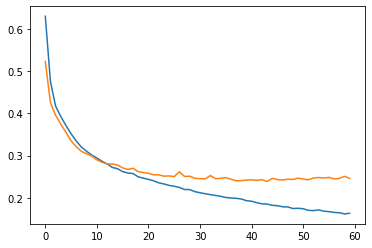

In [ ]:
plt.plot(train_losses)
plt.plot(val_losses)
#Plots for loss

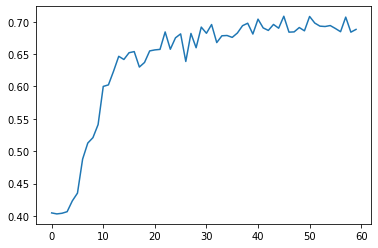

In [ ]:
plt.plot(val_accuracy)
#Plot for F1 score

# Grid Search

In [ ]:
#Grid search for Fine F1 adjustment
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
rocarray = []
for threshold0 in tqdm(thresholds, desc ="T0"):
    for threshold1 in tqdm(thresholds, desc ="T1"):
        for threshold2 in tqdm(thresholds, desc="T2")
            for threshold3 in tqdm(thresholds, desc ="T3"):
                for threshold4 in thresholds:
                    logits_list = np.zeros((1,5))
                    labels_list = np.zeros((1,5))
                    for batch in (valloader):
                        batch[0],batch[1] = batch[0].to("cuda"),batch[1].to("cuda")
                        logits = model(batch[0],batch[1]).to("cpu").detach().numpy() > np.array([threshold0,threshold1,threshold2,threshold3,threshold4])
                        labels = batch[2].numpy()
                        
                        logits_list = np.concatenate((logits_list,logits),0)
                        labels_list = np.concatenate((labels_list,labels),0)
                        
                        torch.cuda.empty_cache()
                    for i in range(logits_list.shape[0]):
                        for j in range(logits_list.shape[1]):
                            if(logits_list[i][2]==1 and j!=2):
                                logits_list[i][j]=0
                    
                    rocarray.append([threshold0,threshold1,threshold2,threshold3,threshold4,f1_score(labels_list[1:], logits_list[1:], average='weighted'),precision_score(labels_list[1:], logits_list[1:], average='weighted'),recall_score(labels_list[1:], logits_list[1:], average='weighted')])

import pandas as pd
import csv
f1df = pd.DataFrame(rocarray)
f1df.to_csv("/content/gdrive/My Drive/CS685/rocbertcnn.csv",index=False,header=['Threshold0','Threshold1','Threshold2','Threshold3','Threshold4','Fine_F1_Score','Precision','Recall'])

In [ ]:
f1df.iloc[int(f1df[[5]].idxmax())]
#Finding Maximum F1 score thresholds

0    0.100000
1    0.100000
2    0.400000
3    0.100000
4    0.500000
5    0.601184
Name: 4, dtype: float64

#Plot confusion matrices

([<matplotlib.axis.YTick at 0x7f2228ad22e8>,
 [Text(0, 0.5, 'Non Fake'), Text(0, 1.5, 'Fake')])

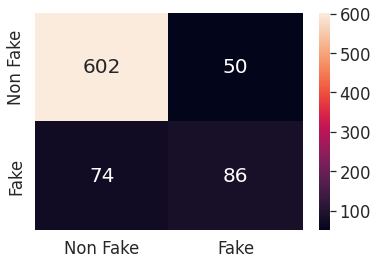

In [ ]:
confusion_matrix = np.array([[602,50], [74,86]])
df_cm=pd.DataFrame(confusion_matrix,columns=['Non Fake', 'Fake'])
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.5) # for label size
sn.heatmap(df_cm, annot=True,fmt="d", annot_kws={"size": 20}) # font size
plt.yticks(np.arange(2)+0.5,('Non Fake','Fake'), va="center") #Centering the y labels and naming them
# plt.title("Confusion matrix for Hostile classification")